## **Importing Libraries** 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['GLOG_minloglevel'] = '2'
import time
import gc
import cv2
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, HTML
import requests
from PIL import Image
from io import BytesIO
import math
import joblib
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import tensorflow as tf

2024-06-09 23:30:34.263199: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 23:30:34.263263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 23:30:34.263286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
WLASL_DIR = 'datasets/wlasl_dataset'
WLASL_VIDEO_DIR = 'datasets/wlasl_dataset/videos'
WLASL_VIDEO_BACKUP_DIR= 'datasets/wlasl2000_resized/videos'
NPY_DIR = 'working/landmarks'
GISLR_DIR = 'datasets/google_isolated_sl'
os.makedirs('working', exist_ok=True)
os.makedirs(NPY_DIR, exist_ok=True)

if os.path.exists("tokens.txt"):
    with open("tokens.txt", "r") as file:
        lines = file.readlines()
        HTTP_TOKEN = lines[0].rstrip()
        CHAT_ID = lines[1].rstrip()

MAX_FRAME_LENGTH = 64

---

## **JSON Load**

In [3]:
def get_dataset_json(json):
    data = []
    
    for i in tqdm(range(len(json)), ncols=100):
        gloss = json[i]['gloss']
        instances = json[i]['instances']
        for instance in instances:
            video_id = instance['video_id']
            if os.path.exists(os.path.join(WLASL_VIDEO_DIR, f'{video_id}.mp4')):
                video_path = os.path.join(WLASL_VIDEO_DIR, f'{video_id}.mp4')
            elif os.path.exists(os.path.join(WLASL_VIDEO_BACKUP_DIR, f'{video_id}.mp4')):
                video_path = os.path.join(WLASL_VIDEO_BACKUP_DIR, f'{video_id}.mp4')
            else:
                continue
            
            frame_start = instance['frame_start']
            frame_end = instance['frame_end']
            split = instance['split']
            data.append({
                'gloss': gloss,
                'video_path': video_path,
                'frame_start': frame_start,
                'frame_end': frame_end,
                'split': split
            })
    
    return pd.DataFrame(data)

In [4]:
with open('datasets/wlasl_dataset/WLASL_v0.3.json', 'r') as json_file:
    wlasl_json = json.load(json_file)

with open('datasets/google_isolated_sl/sign_to_prediction_index_map.json', 'r') as json_file:
    gislr_json = json.load(json_file)

wlasl_df = get_dataset_json(wlasl_json)
gislr_labels = list(gislr_json.keys())

100%|█████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 8966.85it/s]


In [5]:
wlasl_df[wlasl_df['gloss'].str.contains('taste')]

,gloss,video_path,frame_start,frame_end,split
13248,taste,datasets/wlasl2000_resized/videos/56969.mp4,344,416,train
13249,taste,datasets/wlasl_dataset/videos/56970.mp4,1,-1,train
13250,taste,datasets/wlasl_dataset/videos/56971.mp4,1,-1,train
13251,taste,datasets/wlasl_dataset/videos/56972.mp4,1,-1,val
13252,taste,datasets/wlasl_dataset/videos/56973.mp4,1,-1,train
13253,taste,datasets/wlasl2000_resized/videos/56974.mp4,1,-1,val
13254,taste,datasets/wlasl_dataset/videos/56975.mp4,1,-1,train
13255,taste,datasets/wlasl2000_resized/videos/56976.mp4,1,-1,train
13256,taste,datasets/wlasl2000_resized/videos/56977.mp4,1,-1,test
13257,taste,datasets/wlasl_dataset/videos/56978.mp4,1,-1,train


---

## **Landmark Detection**

In [6]:
HAND_FILTERS = list(range(21))
POSE_FILTERS = [0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16]
FACE_FILTERS = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
HAND_FILTERS_LEN = len(HAND_FILTERS) # 21
POSE_FILTERS_LEN = len(POSE_FILTERS) # 13
FACE_FILTERS_LEN = len(FACE_FILTERS) # 40
TOTAL_FILTERS_LEN = HAND_FILTERS_LEN * 2 + POSE_FILTERS_LEN + FACE_FILTERS_LEN

In [7]:
vision_running_mode = vision.RunningMode
base_options = python.BaseOptions

hands_options_image = vision.HandLandmarkerOptions(
    running_mode=vision_running_mode.IMAGE,
    min_hand_detection_confidence=0.55,
    base_options=base_options(model_asset_path='datasets/mediapipe_models/hand_landmarker.task'),
    num_hands=2
)

pose_options_image = vision.PoseLandmarkerOptions(
    running_mode=vision_running_mode.IMAGE,
    min_pose_detection_confidence=0.55,
    base_options=base_options(model_asset_path='datasets/mediapipe_models/pose_landmarker_full.task')
)

face_options_image = vision.FaceLandmarkerOptions(
    running_mode=vision_running_mode.IMAGE,
    min_face_detection_confidence=0.55,
    base_options=base_options(model_asset_path='datasets/mediapipe_models/face_landmarker.task')
)

hands_options_video = vision.HandLandmarkerOptions(
    running_mode=vision_running_mode.VIDEO,
    min_hand_detection_confidence=0.55,
    base_options=base_options(model_asset_path='datasets/mediapipe_models/hand_landmarker.task'),
    num_hands=2
)

pose_options_video = vision.PoseLandmarkerOptions(
    running_mode=vision_running_mode.VIDEO,
    min_pose_detection_confidence=0.55,
    base_options=base_options(model_asset_path='datasets/mediapipe_models/pose_landmarker_full.task')
)

face_options_video = vision.FaceLandmarkerOptions(
    running_mode=vision_running_mode.VIDEO,
    min_face_detection_confidence=0.55,
    base_options=base_options(model_asset_path='datasets/mediapipe_models/face_landmarker.task')
)

hands_detector_image = vision.HandLandmarker.create_from_options(hands_options_image)
pose_detector_image = vision.PoseLandmarker.create_from_options(pose_options_image)
face_detector_image = vision.FaceLandmarker.create_from_options(face_options_image)
IMAGE_DETECTORS = (hands_detector_image, pose_detector_image, face_detector_image)

I0000 00:00:1717950637.035602   99628 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717950637.077262   99759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717950637.095492   99770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1717950637.099689   99628 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1717950637.162604   99782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabl

In [8]:
def detect(detector, image, frame_timestamp=None):
    if frame_timestamp is None:
        return detector.detect(image)
    else:
        return detector.detect_for_video(image, frame_timestamp)

def process_landmarks(landmarks, filters, start_idx, landmarks_array):
    for i in filters:
        landmarks_array[start_idx] = [landmarks[i].x, landmarks[i].y]
        start_idx += 1
    return start_idx

def extract_landmarks_from_image(image, detectors, timestamp=None):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
    
    hands_detector, pose_detector, face_detector = detectors

    with ThreadPoolExecutor() as executor:
        detect_args = (mp_image, timestamp) if timestamp != None else (mp_image,)
        
        hands_future = executor.submit(detect, hands_detector, *detect_args)
        pose_future = executor.submit(detect, pose_detector, *detect_args)
        face_future = executor.submit(detect, face_detector, *detect_args)
        
        hand_result = hands_future.result()
        pose_result = pose_future.result()
        face_result = face_future.result()

    hand_landmarks = hand_result.hand_landmarks
    pose_landmarks = pose_result.pose_landmarks
    face_landmarks = face_result.face_landmarks

    landmarks_array = np.full((TOTAL_FILTERS_LEN, 2), np.nan)
    arr_idx = 0
    
    if hand_landmarks:
        if hand_result.handedness[0].index == 1:
            arr_idx += HAND_FILTERS_LEN
        
        for landmarks in hand_landmarks:
            arr_idx = process_landmarks(landmarks, HAND_FILTERS, arr_idx, landmarks_array)
        
        if arr_idx == HAND_FILTERS_LEN:
            arr_idx += HAND_FILTERS_LEN
    else:
        arr_idx += HAND_FILTERS_LEN*2

    if pose_landmarks:
        arr_idx = process_landmarks(pose_landmarks[0], POSE_FILTERS, arr_idx, landmarks_array)
    else:
        arr_idx += POSE_FILTERS_LEN

    if face_landmarks:
        arr_idx = process_landmarks(face_landmarks[0], FACE_FILTERS, arr_idx, landmarks_array)
    else:
        arr_idx += FACE_FILTERS_LEN
    
    return landmarks_array

def extract_landmarks_from_video(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = round(cap.get(cv2.CAP_PROP_FPS))
    frame_duration_ms = 1000 / fps
    
    hands_detector_video = vision.HandLandmarker.create_from_options(hands_options_video)
    pose_detector_video = vision.PoseLandmarker.create_from_options(pose_options_video)
    face_detector_video = vision.FaceLandmarker.create_from_options(face_options_video)
    VIDEO_DETECTORS = (hands_detector_video, pose_detector_video, face_detector_video)
    
    if start_frame < 1:
        start_frame = 1
    elif start_frame > total_frames:
        start_frame = 1
    
    if end_frame < 0 or end_frame > total_frames:
        end_frame = total_frames
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame - 1)
    video_landmarks = np.zeros((end_frame - start_frame + 1, TOTAL_FILTERS_LEN, 2), dtype=object)
    
    for frame_idx in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        
        timestamp = int((frame_idx - 1) * frame_duration_ms)
        
        # landmarks = extract_landmarks_from_image(frame, IMAGE_DETECTORS)
        landmarks = extract_landmarks_from_image(frame, VIDEO_DETECTORS, timestamp)
        video_landmarks[frame_idx - start_frame] = landmarks
    
    cap.release()
    return video_landmarks

In [9]:
def draw_landmarks_image(image, landmarks, dot_size=5):
    for landmark in landmarks:
        x, y = landmark
        if not np.isnan(x) and not np.isnan(y):
            cv2.circle(image, (int(x * image.shape[1]), int(y * image.shape[0])), dot_size, (0, 255, 0), -1)
    return image


def draw_landmarks_video(input_path, output_path, video_landmarks, start_frame=1, end_frame=-1, dot_size=5):
    cap = cv2.VideoCapture(input_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'avc1'), fps, (frame_width, frame_height))

    if end_frame == -1 or end_frame > total_frames:
        end_frame = total_frames

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame - 1)

    while cap.isOpened():
        frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_number > end_frame:
            break

        ret, frame = cap.read()
        if not ret:
            break

        frame_landmarks = video_landmarks[frame_number - 1]
        annotated_frame = draw_landmarks_image(frame, frame_landmarks, dot_size=dot_size)

        out.write(annotated_frame)

    cap.release()
    out.release()


In [10]:
def plot_frame(frame, ax):
    ax.clear()
    x = frame[:, 0]
    y = frame[:, 1]
    ax.scatter(x, y, color='dodgerblue')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def animate_frames(data):
    fig, ax = plt.subplots()
    anim = FuncAnimation(fig, lambda frame: plot_frame(data[frame], ax), frames=range(data.shape[0]), interval=100)
    plt.close(fig)
    return HTML(anim.to_jshtml())

/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


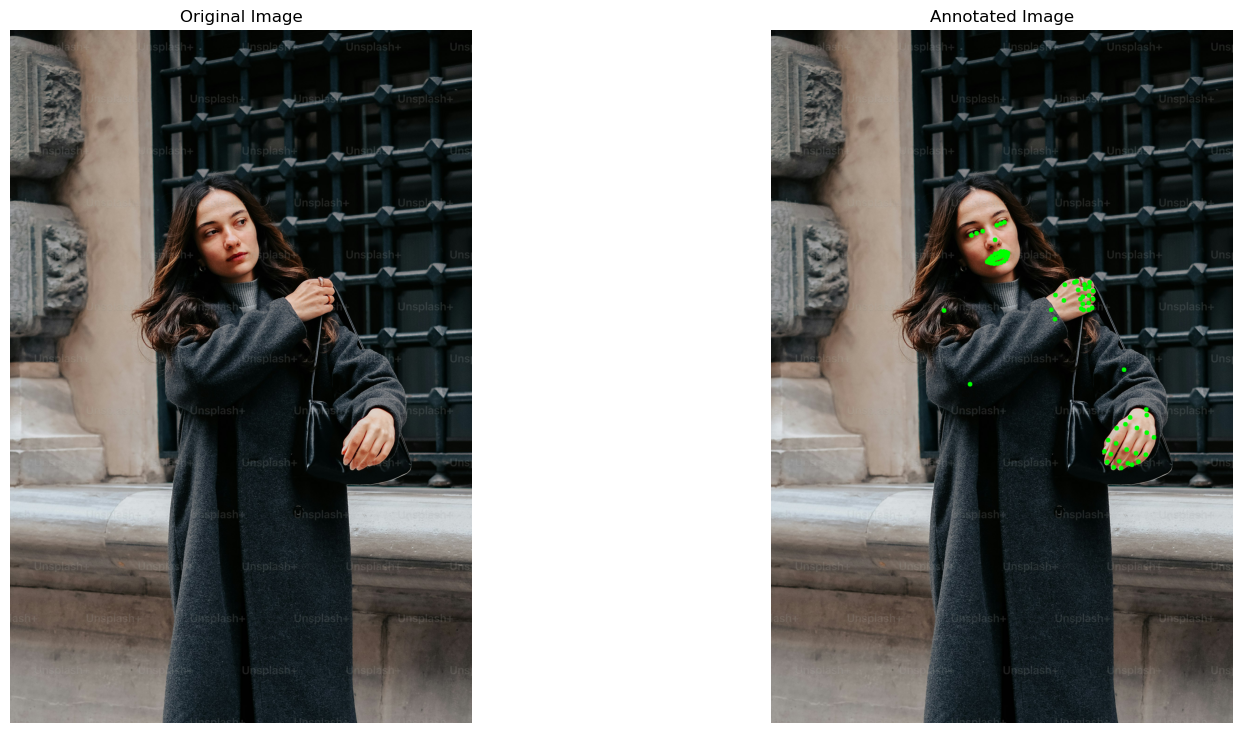

In [11]:
# Fetch and process the image
image_url = 'https://plus.unsplash.com/premium_photo-1673287635678-8d812deb4fc2?q=80&w=1974&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' # all
# image_url = 'https://images.unsplash.com/photo-1626006864202-946131e379dd?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'# only left hand
# image_url = 'https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?q=80&w=1974&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' # only face
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

# Annotate the image
test_image_landmarks = extract_landmarks_from_image(img, IMAGE_DETECTORS)
annotated_img = draw_landmarks_image(img.copy(), test_image_landmarks, 10)

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Original image
axes[0].imshow(img[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Original Image')

# Annotated image
axes[1].imshow(annotated_img[:,:,::-1])
axes[1].axis('off')
axes[1].set_title('Annotated Image')

plt.show()

# Save the annotated image
Image.fromarray(annotated_img).save("working/test_output_image.png")

In [12]:
test_video = wlasl_df.iloc[353]
print(test_video)
video_path = test_video['video_path']
frame_start = test_video['frame_start']
frame_end = test_video['frame_end']
output_path = 'working/test_output_video.mp4'
test_video_landmarks = extract_landmarks_from_video(video_path, frame_start, frame_end)
draw_landmarks_video(video_path, output_path, test_video_landmarks, start_frame=frame_start, end_frame=frame_end, dot_size=5)

gloss                                                   no
video_path     datasets/wlasl2000_resized/videos/38541.mp4
frame_start                                              1
frame_end                                               -1
split                                                train
Name: 353, dtype: object


I0000 00:00:1717950639.452933   99628 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1717950639.463390   99893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717950639.473049   99908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1717950639.473732   99628 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1717950639.523109   99917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717950639

In [13]:
gc.collect()

0

In [14]:
animate_frames(test_video_landmarks)

---

## **Landmark Encoding**

In [15]:
try:
    for i in tqdm(range(len(wlasl_df)), ncols=100):
        npy_path = os.path.join(NPY_DIR, f'{i}.npy')
        if os.path.exists(npy_path): continue
        video_path = wlasl_df.iloc[i]['video_path']
        start = wlasl_df.iloc[i]['frame_start']
        end = wlasl_df.iloc[i]['frame_end']
        
        try:
            video_landmarks = extract_landmarks_from_video(video_path, start, end).astype(np.float32)
            np.save(npy_path, video_landmarks, allow_pickle=True)
        
        except Exception as e:
            print(f"\nError loading {video_path}\n{e}")
            continue
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

100%|█████████████████████████████████████████████████████| 21083/21083 [00:00<00:00, 156652.32it/s]


In [16]:
landmarks_dict = {}

if not os.path.exists('working/landmarks.npz'):
    for filename in tqdm(os.listdir(NPY_DIR), desc='Processing files', ncols=100):
        if filename.endswith('.npy'):
            key = filename.split('.')[0]
            landmarks = np.load(os.path.join(NPY_DIR, filename), allow_pickle=True)
            landmarks_dict[key] = landmarks

    np.savez_compressed('working/landmarks.npz', **landmarks_dict)

---

## **Data Augmentation**

In [17]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data_flat = data[:, :, :2].reshape(-1, 2)
    non_zero_flat_indices = non_zero[:, 0] * landmarks + non_zero[:, 1]
    data_flat[non_zero_flat_indices] -= center
    data_flat[non_zero_flat_indices] = np.dot(data_flat[non_zero_flat_indices], rotation_matrix.T)
    data_flat[non_zero_flat_indices] += center
    data[:, :, :2] = data_flat.reshape(frames, landmarks, 2)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    angle = np.random.choice([np.random.uniform(-30, -10), np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def zoom(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.5 * (landmarks - 42))
    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask, :] = 0
    return data

def drop_frames(data, seed=None):
    if seed is not None:
        np.random.seed(seed)

    drop_fraction=0.2
    
    frames, landmarks, _ = data.shape
    num_drop = int(frames * drop_fraction)
    
    drop_indices = np.random.choice(frames, num_drop, replace=False)
    
    keep_mask = np.ones(frames, dtype=bool)
    keep_mask[drop_indices] = False
    
    data_dropped = data[keep_mask]
    
    return data_dropped

In [18]:
def augment_video(data, min_aug=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    aug_functions = [rotate_z, zoom, shift, mask, drop_frames]
    np.random.shuffle(aug_functions)
    applied_functions = 0
    
    while applied_functions < min_aug and aug_functions:
        fun = aug_functions.pop()
        if np.random.rand() < 0.5:
            data = fun(data, seed)
            # print(f"Applied {fun.__name__}")
            applied_functions += 1
    
    return data

In [19]:
def test_augment_img(data, img):
    real_img = img.copy()
    for landmark in data[0]:
        x, y = landmark
        if not np.isnan(x) and not np.isnan(y):
            cv2.circle(real_img, (int(x * img.shape[1]), int(y * real_img.shape[0])), 10, (0, 255, 0), -1)
    plt.figure(figsize=(8, 8))
    plt.imshow(real_img[:,:,::-1])
    plt.axis('off')
    plt.show()
    
    aug_functions = [rotate_z, zoom, shift, mask]
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))
    for i, fun in enumerate(aug_functions):
        ax = axs[i // 2, i % 2]
        ax.imshow(draw_landmarks_image(img.copy(), fun(data.copy())[0], 20))
        ax.axis('off')
        ax.set_title(fun.__name__)

/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


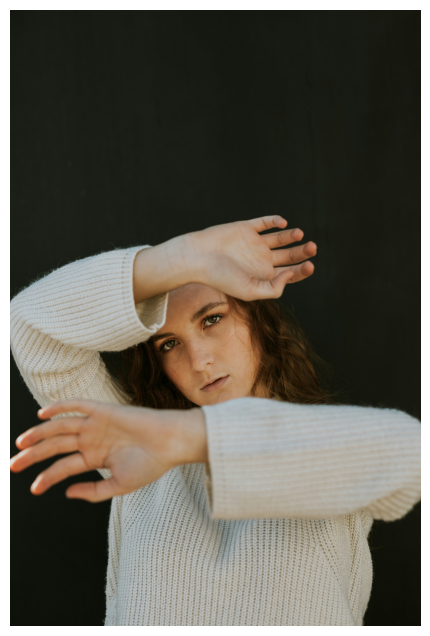

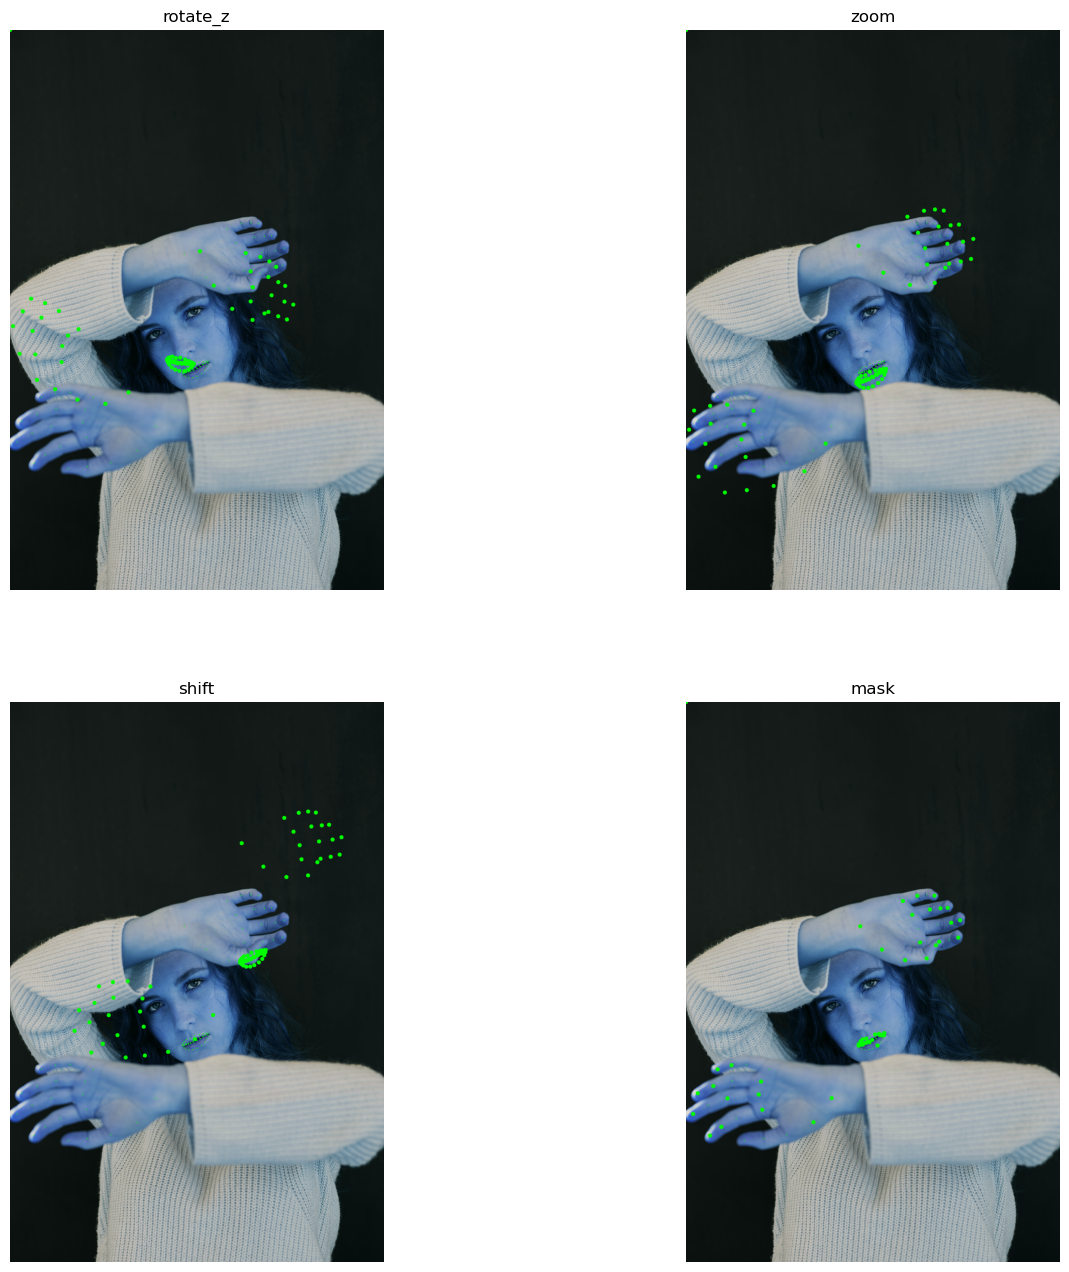

In [20]:
# image_url = 'https://www.solidbackgrounds.com/images/1080x1920/1080x1920-black-solid-color-background.jpg'
image_url = 'https://images.unsplash.com/photo-1515294898968-a408405d7674'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# frame_landmarks = load_pq_data('datasets/google_isolated_sl/train_landmark_files/18796/2324430.parquet')[0]
# np.nan_to_num(frame_landmarks, copy=False, nan=0)

frame_landmarks = extract_landmarks_from_image(img, IMAGE_DETECTORS)
frame_landmarks = np.expand_dims(frame_landmarks, axis=0)

test_augment_img(frame_landmarks.copy(), img)

In [21]:
# video_path = 'datasets/wlasl_dataset/videos/69241.mp4'
# frame_start = 1
# frame_end = -1
# test_video_landmarks = extract_landmarks_from_video(video_path, frame_start, frame_end)
# draw_landmarks_video(
#     video_path,
#     'working/test_output_video_non_augmented.mp4',
#     test_video_landmarks,
#     start_frame=frame_start,
#     end_frame=frame_end
# )

# augmented_video_landmarks = augment_video(test_video_landmarks.copy(), 4)
# draw_landmarks_video(
#     video_path,
#     'working/test_output_video_augmented.mp4',
#     augmented_video_landmarks,
#     start_frame=frame_start,
#     end_frame=frame_end
# )

I0000 00:00:1717950649.350151   99628 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1717950649.355235  100291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717950649.362184  100308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1717950649.362783   99628 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1717950649.398050  100316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717950649

IndexError: index 60 is out of bounds for axis 0 with size 60

---

## **Preprocess Functions**

In [22]:
def padding(X, length=None, pad=0):
    if length is None:
        length = X.shape[0]
    
    if X.shape[0] > length:
        X_padded = X[:length]
    else:
        pad_length = length - X.shape[0]
        X_padded = np.pad(
            X, ((0, pad_length), (0, 0), (0, 0)),
            mode='constant', constant_values=pad
        )
            
    return X_padded

In [23]:
def remove_no_hands(video):
    frames_to_keep = []
    for i, frame in enumerate(video):
        hand_landmarks_data = frame[:43]
        if not np.all(np.isnan(hand_landmarks_data)):
            frames_to_keep.append(i)
    video_with_hands = video[frames_to_keep]
    return video_with_hands

In [24]:
def normalize_video(video):
    lhand_indices = np.arange(0, 21)
    rhand_indices = np.arange(21, 42)
    face_indices = np.arange(55, 95)

    relevant_indices = np.concatenate((lhand_indices, rhand_indices, face_indices))
    relevant_arr = video[:, relevant_indices]
    reshaped_arr = relevant_arr.reshape(-1, relevant_arr.shape[-1])
    
    mean_val = np.mean(reshaped_arr, axis=0)
    std_val = np.std(reshaped_arr, axis=0)
    
    normalized_data = (video - mean_val) / std_val
    normalized_data = np.where(np.isfinite(normalized_data), normalized_data, 0)
    
    return normalized_data

In [25]:
def is_dominant_hand(video):

    left_hand_sum = np.sum(~np.isnan(video[:, slice(0, 21)]), axis=1)
    right_hand_sum = np.sum(~np.isnan(video[:, slice(21, 42)]), axis=1)

    left_dominant_count = np.sum(left_hand_sum >= right_hand_sum)
    right_dominant_count = np.sum(left_hand_sum < right_hand_sum)

    return left_dominant_count > right_dominant_count

In [26]:
def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

---

## **Data Load and Preprocess**

In [27]:
def get_data_and_labels_npz(df, landmarks_dict, filtered_labels=None):
    if filtered_labels is None:
        filtered_labels = []
    x = []
    y = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), ncols=100):
        real_i = row['original_index']
        gloss = row['gloss']
        
        if gloss not in filtered_labels: continue
        
        video = landmarks_dict[str(real_i)].astype('float32')
        
        x.append(video)
        y.append(gloss)
    
    return x, np.array(y)

In [28]:
def load_pq_data(pq_path):
    data_columns = ['x','y']
    data = pd.read_parquet(pq_path, columns = data_columns)
    n_frames = int(len(data) / 543)
    data = data.values.reshape(n_frames, 543, len(data_columns))
    
    left_hand_indices = [468 + i for i in HAND_FILTERS]
    right_hand_indices = [468 + 21 + 33 + i for i in HAND_FILTERS]
    pose_indices = [468 + 21 + i for i in POSE_FILTERS]
    face_indices = FACE_FILTERS
    all_indices = left_hand_indices + right_hand_indices + pose_indices + face_indices
    filtered_data = data[:, all_indices, :]
    
    return filtered_data.astype(np.float32)

def get_data_and_labels_pq(df, pq_dir, filtered_labels=None):
    if filtered_labels is None:
        filtered_labels = []
    x = []
    y = []
    
    for i, row in tqdm(df.iterrows(), total=len(df), ncols=100, desc='Loading data'):
        video = load_pq_data(pq_dir+'/'+row['path'])
        gloss = row['sign']
        
        if gloss not in filtered_labels: continue
        
        x.append(video)
        y.append(gloss)
    
    return x, np.array(y)

In [29]:
def preprocess(data, augment=False):
    x = []
    
    for video in tqdm(data, total=len(data), ncols=100, desc='Preprocessing'):
        aug_video = video.copy()
        if not is_dominant_hand(aug_video):
            hflip(aug_video)
        
        aug_video = remove_no_hands(aug_video)
        if aug_video.shape[0] == 0: continue
        
        np.nan_to_num(aug_video, copy=False, nan=0)
        
        if augment:
            aug_video = augment_video(aug_video, 4)
        
        aug_video = padding(aug_video, MAX_FRAME_LENGTH, -100)
        
        # aug_video = normalize_video(aug_video)
        
        x.append(aug_video)
    
    return np.array(x)

In [30]:
start_time = time.time()

wlasl_glosses = wlasl_df['gloss'].unique().tolist()

wlasl_glosses_lower = [gloss.lower() for gloss in wlasl_glosses]
gislr_labels_lower = [label.lower() for label in gislr_labels]

filtered_labels = list(set(wlasl_glosses_lower) & set(gislr_labels_lower))


In [31]:
gc.collect()

pq_df = pd.read_csv(f'{GISLR_DIR}/train.csv')

x, y = get_data_and_labels_pq(pq_df, GISLR_DIR, filtered_labels=filtered_labels)

x_train_gislr, x_val_gislr, y_train_gislr, y_val_gislr = train_test_split(x, y, test_size=0.2, random_state=42)
x_val_gislr, x_test_gislr, y_val_gislr, y_test_gislr = train_test_split(x_val_gislr, y_val_gislr, test_size=0.5, random_state=42)

x_train_gislr = preprocess(x_train_gislr, augment=True)
x_val_gislr = preprocess(x_val_gislr)
x_test_gislr = preprocess(x_test_gislr)

print("GISLR training data shape:", x_train_gislr.shape, y_train_gislr.shape)
print("GISLR validation data shape:", x_val_gislr.shape, y_val_gislr.shape)
print("GISLR testing data shape:", x_test_gislr.shape, y_test_gislr.shape)

Preprocessing: 100%|██████████████████████████████████████████| 7569/7569 [00:01<00:00, 6732.43it/s]


GISLR training data shape: (60546, 64, 95, 2) (60546,)
GISLR validation data shape: (7568, 64, 95, 2) (7568,)
GISLR testing data shape: (7569, 64, 95, 2) (7569,)


In [32]:
gc.collect()

all_landmarks = np.load('working/landmarks.npz', allow_pickle=True)

wlasl_df['original_index'] = wlasl_df.index

train_df = wlasl_df[wlasl_df['split'] == 'train']
val_df = wlasl_df[wlasl_df['split'] == 'val']
test_df = wlasl_df[wlasl_df['split'] == 'test']

x_train_wlasl, y_train_wlasl = get_data_and_labels_npz(train_df, all_landmarks, filtered_labels=filtered_labels)
x_val_wlasl, y_val_wlasl = get_data_and_labels_npz(val_df, all_landmarks, filtered_labels=filtered_labels)
x_test_wlasl, y_test_wlasl = get_data_and_labels_npz(test_df, all_landmarks, filtered_labels=filtered_labels)

x_train_wlasl = preprocess(x_train_wlasl, augment=True)
x_val_wlasl = preprocess(x_val_wlasl)
x_test_wlasl = preprocess(x_test_wlasl)

print("WLASL training data shape:", x_train_wlasl.shape, y_train_wlasl.shape)
print("WLASL validation data shape:", x_val_wlasl.shape, y_val_wlasl.shape)
print("WLASL test data shape:", x_test_wlasl.shape, y_test_wlasl.shape)

Preprocessing: 100%|████████████████████████████████████████████| 386/386 [00:00<00:00, 5561.40it/s]

WLASL training data shape: (1943, 64, 95, 2) (1943,)
WLASL validation data shape: (489, 64, 95, 2) (489,)
WLASL test data shape: (386, 64, 95, 2) (386,)


In [33]:
gc.collect()

x_train = np.concatenate((x_train_gislr, x_train_wlasl), axis=0)
y_train = np.concatenate((y_train_gislr, y_train_wlasl), axis=0)

x_val = np.concatenate((x_val_gislr, x_val_wlasl), axis=0)
y_val = np.concatenate((y_val_gislr, y_val_wlasl), axis=0)

# x_test = np.concatenate((x_test_gislr, x_test_wlasl), axis=0)
# y_test = np.concatenate((y_test_gislr, y_test_wlasl), axis=0)

train_permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[train_permutation]
y_train = y_train[train_permutation]

val_permutation = np.random.permutation(x_val.shape[0])
x_val = x_val[val_permutation]
y_val = y_val[val_permutation]

# test_permutation = np.random.permutation(x_test.shape[0])
# x_test = x_test[test_permutation]
# y_test = y_test[test_permutation]

print("Combined and shuffled training set shape:", x_train.shape, y_train.shape)
print("Combined and shuffled validation set shape:", x_val.shape, y_val.shape)
# print("Combined and shuffled test set shape:", x_test.shape, y_test.shape)

Combined and shuffled training set shape: (62489, 64, 95, 2) (62489,)
Combined and shuffled validation set shape: (8057, 64, 95, 2) (8057,)


In [34]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
# y_test = label_encoder.transform(y_test)

joblib_file = "label_encoder.joblib"
joblib.dump(label_encoder, joblib_file)

['label_encoder.joblib']

In [ ]:
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

In [35]:
print(len(np.unique(y_train)))

201


In [36]:
test_num = 3
print(label_encoder.inverse_transform([y_train[test_num]]))
animate_frames(x_train[test_num])

['give']


---

## **Modelling**

In [37]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
# from transformers import TFBertModel

tf.keras.backend.clear_session()

In [38]:
N_EPOCHS = 100
NUM_CLASSES = len(np.unique(y_train))

In [39]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

In [40]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

In [41]:
class EarlyLateDropout(tf.keras.layers.Layer):
    def __init__(self, early_rate, late_rate, switch_epoch, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.early_rate = early_rate
        self.late_rate = late_rate
        self.switch_epoch = switch_epoch
        self.dropout = tf.keras.layers.Dropout(early_rate)
    
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = self.add_weight(name="train_counter", shape=[], dtype=tf.int64, aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        if training:
            dropout_rate = tf.cond(self._train_counter < self.switch_epoch, lambda: self.early_rate, lambda: self.late_rate)
            x = self.dropout(inputs, training=training)
            x = tf.keras.layers.Dropout(dropout_rate)(x, training=training)
            self._train_counter.assign_add(1)
        else:
            x = inputs
        return x

In [42]:
def add_dummy_channel(x):
    dummy_channel = tf.zeros_like(x[:, :, :, :1])
    result = tf.concat([x, dummy_channel], axis=-1)
    return result

In [43]:
def scce_with_ls(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.2)

In [44]:
def create_model():
    input_shape = MAX_FRAME_LENGTH, TOTAL_FILTERS_LEN
    
    base_model = tf.keras.applications.EfficientNetV2B1(
        include_top=False,
        include_preprocessing=False,
        weights='imagenet',
        input_shape=input_shape + (3,)
    )

    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=-100, input_shape=input_shape + (2,)),
        tf.keras.layers.Lambda(add_dummy_channel),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        EarlyLateDropout(early_rate=0.5, late_rate=0.8, switch_epoch=15),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    #     initial_learning_rate=1e-3,
    #     decay_steps=50000,
    #     alpha=1e-2
    # )
    
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            # learning_rate=cosine_decay
        ),
        loss=scce_with_ls,
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=0,
    save_best_only=True
)

# class PrintLR(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         lr = tf.keras.backend.get_value(self.model.optimizer.lr)
#         print(f' - lr {epoch + 1}: {lr}')

# print_lr = PrintLR()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    min_lr=1e-5
)

log_dir =  "working/logs"
os.makedirs(log_dir, exist_ok=True)
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir
)

In [46]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 64, 95, 2)         0         
                                                                 
 lambda (Lambda)             (None, 64, 95, 3)         0         
                                                                 
 efficientnetv2-b1 (Functio  (None, 2, 3, 1280)        6931124   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 early_late_dropout (EarlyL  (None, 1280)              1         
 ateDropout)                                                     
                                                        

In [47]:
%load_ext tensorboard
%tensorboard --logdir "working/logs"

In [48]:
gc.collect()

model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=N_EPOCHS,
    batch_size=64,
    callbacks=[early_stopping, checkpoint_callback, tensorboard, print_lr],
    verbose=1
)

Epoch 1/150


2024-06-09 23:35:52.535004: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-b1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


977/977 [==============================] - ETA: 0s - loss: 5.2827 - accuracy: 0.0091

/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 - lr 1: 0.0009997673332691193
977/977 [==============================] - 94s 68ms/step - loss: 5.2827 - accuracy: 0.0091 - val_loss: 5.0157 - val_accuracy: 0.0261
Epoch 2/150
977/977 [==============================] - 64s 65ms/step - loss: 4.9876 - accuracy: 0.0304 - val_loss: 4.5845 - val_accuracy: 0.0927
Epoch 3/150
977/977 [==============================] - 63s 65ms/step - loss: 4.6259 - accuracy: 0.0778 - val_loss: 4.1649 - val_accuracy: 0.1885
Epoch 4/150
977/977 [==============================] - 63s 65ms/step - loss: 4.3090 - accuracy: 0.1451 - val_loss: 3.8445 - val_accuracy: 0.2811
Epoch 5/150
977/977 [==============================] - 64s 66ms/step - loss: 4.0520 - accuracy: 0.2154 - val_loss: 3.5333 - val_accuracy: 0.3606
Epoch 6/150
977/977 [==============================] - 63s 64ms/step - loss: 3.8459 - accuracy: 0.2755 - val_loss: 3.3941 - val_accuracy: 0.4037
Epoch 7/150
977/977 [==============================] - 64s 66ms/step - loss: 3.6911 - accuracy: 0.3230 - val_lo

In [49]:
url = f"https://api.telegram.org/bot{HTTP_TOKEN}"
params = {
    "chat_id": CHAT_ID,
    "text": "Done Training"
}
try:
    requests.post(url + "/sendMessage", params=params)
except Exception as e:
    print("Failed to send message")

---

## **Test Results**

In [50]:
test_model = load_model('best_model.h5', custom_objects={'EarlyLateDropout': EarlyLateDropout, 'scce_with_ls': scce_with_ls})

In [51]:
label_encoder = joblib.load('label_encoder.joblib')

In [52]:
y_pred_wlasl = test_model.predict(x_test_wlasl)
y_pred_labels_wlasl = np.argmax(y_pred_wlasl, axis=1)
y_pred_decoded_wlasl = label_encoder.inverse_transform(y_pred_labels_wlasl)

report = classification_report(y_test_wlasl, y_pred_decoded_wlasl)
print(report)

13/13 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

       after       0.00      0.00      0.00         2
    airplane       0.67      1.00      0.80         2
         all       1.00      0.67      0.80         3
   alligator       0.00      0.00      0.00         1
      animal       1.00      1.00      1.00         2
     another       0.00      0.00      0.00         1
         any       0.67      1.00      0.80         2
       apple       0.50      0.50      0.50         2
         arm       0.00      0.00      0.00         2
        aunt       1.00      0.50      0.67         2
       awake       1.00      1.00      1.00         1
         bad       1.00      0.50      0.67         2
     balloon       0.67      1.00      0.80         2
        bath       1.00      1.00      1.00         2
     because       0.00      0.00      0.00         2
         bed       0.50      0.50      0.50         2
     bedroom       1.00    

/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/haikal/anaconda3/envs/tf_214/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [53]:
y_pred_gislr = test_model.predict(x_test_gislr)
y_pred_labels_gislr = np.argmax(y_pred_gislr, axis=1)
y_pred_decoded_gislr = label_encoder.inverse_transform(y_pred_labels_gislr)

report = classification_report(y_test_gislr, y_pred_decoded_gislr)
print(report)

237/237 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

       after       0.76      0.38      0.51        34
    airplane       0.86      0.81      0.83        37
         all       0.68      0.63      0.66        41
   alligator       0.75      0.54      0.62        28
      animal       0.49      0.58      0.53        38
     another       0.52      0.74      0.61        31
         any       0.71      0.61      0.66        33
       apple       0.83      0.81      0.82        42
         arm       0.56      0.62      0.59        32
        aunt       0.76      0.80      0.78        44
       awake       0.73      0.70      0.72        47
         bad       0.68      0.49      0.57        39
     balloon       0.61      0.67      0.64        49
        bath       0.72      0.47      0.57        38
     because       0.73      0.82      0.77        44
         bed       0.55      0.78      0.65        27
     bedroom       0.65  